# Modelos de Machine Learning: Benchmarks

## Intro

### Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
import math
import altair as alt

### Carga de Datos

In [2]:
def load_data(df_in):
    df = pd.read_csv(df_in+'.csv')
    df = df.drop("Unnamed: 0", axis=1)
    return df

# Cargar los datos
df = load_data('df_C_S_v3')
#df = df[df['Client'] != 'Boxto']
#df = df[df['Client'] != 'AOV']
df = df.reset_index()

In [3]:
df = df[df['Format_New']=='Video']
#print(len(df[df['Format_New']=='Video']))
#print(len(df))

In [4]:
df['CPV']

6       3.394762
8       0.060510
9       0.022742
10      0.009502
11      0.004582
          ...   
4388    0.026323
4389    0.020815
4390    0.023552
4391    0.022447
4392    0.033980
Name: CPV, Length: 1645, dtype: float64

### Elección Output y features

La regla empírica establece que:

aproximadamente el 68% de los datos caerán dentro de 1 desviación estándar de la media,

alrededor del 95% de los datos caerán dentro de 2 desviaciones estándar y

aproximadamente el 99.7% de los datos caerán dentro de 3 desviaciones estándar de la media.

In [5]:
Variable_Target = 'CPV'

# Calcular la media y la desviación estándar de la variable objetivo y
mean_y, std_y = np.mean(df[Variable_Target]), np.std(df[Variable_Target])
outlier_threshold = 3 * std_y

max_y = mean_y + (3 * std_y)
min_y = mean_y - (3 * std_y)

df = df[df[Variable_Target] <= max_y]
df = df[df[Variable_Target] >= min_y]
df.shape

(1619, 56)

In [6]:
X = df.copy()

# Preparar los datos: Features
X = X[['Año','Mes', 'Objective', 'Cost', 'Country', 'Media_type', 'Traffic_source', 'Client','Format_New','Platform','Strategy','Plataforma','Campaign_Type','Ecommerce','Service_Product']]
       #'Tipo Search', 'Bench Gral CPC',       #'Bench Search CPC', 'Bench GralSch CPL', 'Bench Search CPL',       #'Bench GralSch CTR', 'Bench Search CTR', 'Bench GralSch CR',       #'Bench Search AvgCR', 'Tipo FB', 'Bench GralFB CPC', 'Bench FB CPC',
       #'Bench GralFB CPAction', 'Bench FB CPAction', 'Bench GralFB CTR',       #'Bench FB CTR', 'Bench GralFB CR', 'Bench FB AvgCR', 'Tipo YT',       #'Bench GralYT CPV', 'Bench YT CPV', 'Bench GralYT CTR', 'Bench YT CTR',       #'Bench GralYT VR', 'Bench FB AvgVR']]

X = X.reset_index()

categorical_features = ['Objective', 'Country', 'Media_type', 'Traffic_source', 'Client','Format_New','Platform','Strategy','Plataforma','Campaign_Type','Ecommerce','Service_Product']  #,'Tipo Search','Tipo FB','Tipo YT']

# Preprocesamiento de variables categóricas
X_dum = pd.get_dummies(X, columns=categorical_features)

#Elijo el valor a predecir. CPC: La hipótesis es que el valor de COST es conocido y controlable: El output en rigor será Clicks y expresaremos el resultado en CPC Cost/Clicks
y = df[Variable_Target]

In [7]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_Scaled = scaler.fit_transform(X_dum[['Año','Mes','Cost']])

pca = PCA(n_components=2)  # Aquí estamos conservando solo una componente principal
X_pca = pca.fit_transform(X_Scaled)
X_pca = pd.DataFrame(X_pca)

X_dum['X_pca_0'] = X_pca[0]
X_dum['X_pca_1'] = X_pca[1]
X['X_pca_0'] = X_pca[0]
X['X_pca_1'] = X_pca[1]

In [8]:
X_pca

,0,1
0,-1.392734,0.053703
1,-1.282583,0.274825
2,-1.295022,0.249854
3,-1.203913,0.432750
4,-1.323267,0.193154
...,...,...
1614,-0.321447,-0.342529
1615,-0.205635,-0.110044
1616,-0.320916,-0.341463
1617,-0.205268,-0.109307


In [9]:
import joblib
joblib.dump(scaler, 'scaler_model_CPV.joblib')
joblib.dump(pca, 'pca_model_CPV.joblib')

['pca_model_CPV.joblib']

In [10]:
# Separo en conjuntos de Train y de Test
#X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.2, random_state=0)
X_train = X_dum
y_train = y


## RandomForest

( MSE_test = 88 | RMSE_test = 9.3 | MAE_test = 2 | r2= 0.3) Agrego Año y Mes  - Saco antigüedad

rf = RandomForestRegressor(n_estimators=20, max_depth=10, min_samples_split=4, min_samples_leaf=4)

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV

In [30]:
rf = RandomForestRegressor(n_estimators=60, max_depth=7, min_samples_split=4, min_samples_leaf=6)

In [31]:
rf.fit(X_train.drop('index',axis=1), y_train)

RandomForestRegressor(max_depth=7, min_samples_leaf=6, min_samples_split=4,
                      n_estimators=60)

In [34]:
joblib.dump(rf, "model_rf_CPV.joblib")

['model_rf_CPV.joblib']

In [ ]:
# Para cargar el modelo

# Cargar el modelo desde el archivo
#modelo_cargado = joblib.load("model_rf_CPV.joblib")

# Ahora puedes usar el modelo cargado para hacer predicciones
#predicciones = modelo_cargado.predict(X_test)

In [61]:
version = [1,2,3,4,5,6,7,8,9,10,11,12]
RMSE = [0.41,0.39,0.49,0.38,0.38,0.41,0.38,0.36,0.43,0.30,0.25,0.24]

Algos = ['0_Media','1_MediaCliente','3_Regresión_Lineal','4_Árbol_Simple','5_Arbol_regularizado','6_KNN','7_RandomForest','8_XGBoost']
RMSE_algos = [0.52,0.57,0.34,0.32,0.39,0.41,0.25,0.24]


In [62]:
df_versiones = pd.DataFrame({ 'version': version, 'RMSE': RMSE})
df_modelos = pd.DataFrame({ 'version': Algos, 'RMSE': RMSE_algos})

In [63]:
chart = alt.Chart(df_modelos).mark_bar().encode(
    x='version',
    y='RMSE'
).properties(width=600)

chart

alt.Chart(...)

In [109]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [110]:
# Definir los hiperparámetros a ajustar
parameters = {'learning_rate': [0.01, 0.05, 0.075, 0.1],
              'max_depth': [8, 10, 15],
              'n_estimators': [30, 70, 80, 100, 150]}

In [111]:
# Configurar la validación cruzada
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [113]:
# Realizar la búsqueda de parámetros
grid_search = GridSearchCV(estimator=xgboost, param_grid=parameters, cv=kfold, scoring='neg_mean_squared_error', verbose = 3)
grid_result = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END learning_rate=0.01, max_depth=8, n_estimators=30;, score=-76.516 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=8, n_estimators=30;, score=-64.464 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=8, n_estimators=30;, score=-68.628 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=8, n_estimators=30;, score=-99.896 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=8, n_estimators=30;, score=-98.069 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=8, n_estimators=70;, score=-74.229 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=8, n_estimators=70;, score=-63.492 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=8, n_estimators=70;, score=-78.838 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=8, n_estimators=70;, score=-87.820 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=8, n_estimators=70;, s

In [114]:
# Imprimir los resultados
print("Mejor: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))

Mejor: -73.077696 usando {'learning_rate': 0.05, 'max_depth': 15, 'n_estimators': 30}


In [233]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
X_train_xgb_prueba = X_train.copy()
X_train_xgb_prueba = X_train_xgb_prueba.reset_index()
y_train_xgb_prueba = y_train.copy()
y_train_xgb_prueba = y_train_xgb_prueba.reset_index()


X_train_xgb_prueba = X_train_xgb_prueba.drop('index', axis=1)
y_train_xgb_prueba = y_train_xgb_prueba.drop('index', axis=1)

In [234]:
mse_test_list_total = dict()
mse_train_list_total = dict()
for i in [2,3,4,5,6,7,8,9,10,11,12,13]:
    print(i)
    mse_test_list = []
    mse_train_list = []
    for train_index, test_index in kf.split(X_train_xgb_prueba):
        X_train_cv, X_test_cv = X_train_xgb_prueba.iloc[train_index], X_train_xgb_prueba.iloc[test_index]
        y_train_cv, y_test_cv = y_train_xgb_prueba.iloc[train_index], y_train_xgb_prueba.iloc[test_index]
        
        # Inicializar el modelo de clasificación
        xgboost_cv = xgb.XGBRegressor(learning_rate=0.08, max_depth=i, n_estimators=40)
    
        # Ajustar el modelo con los datos de entrenamiento
        xgboost_cv.fit(X_train_cv, y_train_cv)
    
        # Hacer predicciones en los datos de prueba
        y_pred_test_cv = xgboost_cv.predict(X_test_cv)
        y_pred_train_cv = xgboost_cv.predict(X_train_cv)
    
        # Calcular la precisión y agregarla a la lista de puntuaciones
        mse_test = mean_squared_error(y_test_cv, y_pred_test_cv)
        mse_train = mean_squared_error(y_train_cv, y_pred_train_cv)
        #print(y_test_cv)
        #print(y_pred_cv)
        mse_test_list.append(mse_test)
        mse_train_list.append(mse_train)
        
    mse_cv_test = np.mean(mse_test_list)
    mse_test_list_total[i] = mse_cv_test
    mse_cv_train = np.mean(mse_train_list)
    mse_train_list_total[i] = mse_cv_train
print(mse_cv_test)
print(mse_cv_train)

df_curve = pd.DataFrame(list(mse_test_list_total.items()), columns=['Index', 'ErrorTest'])
df_curve_2 = pd.DataFrame(list(mse_train_list_total.items()), columns=['Index', 'ErrorTrain'])
df_curve = pd.merge(df_curve,df_curve_2,on='Index',how='left')
#df_curve = pd.DataFrame(mse_test_list_total)

2
3
4
5
6
7
8
9
10
11
12
13
0.080730994729635
0.005020479967216067


In [235]:
df_curve

,Index,ErrorTest,ErrorTrain
0,2,0.150307,0.144161
1,3,0.122112,0.113112
2,4,0.101056,0.087376
3,5,0.086745,0.066908
4,6,0.079046,0.048782
5,7,0.076124,0.035272
6,8,0.075557,0.024775
7,9,0.075954,0.018069
8,10,0.075966,0.012600
9,11,0.076844,0.008466


In [236]:
# Supongamos que tienes un DataFrame llamado 'df' con columnas "indice", "columna_A" y "columna_B"

# Convertir el DataFrame de pandas a un formato aceptado por Altair
df_altair = pd.melt(df_curve, id_vars=['Index'], value_vars=['ErrorTest', 'ErrorTrain'])

# Crear el gráfico de líneas divididas por color en Altair
line_chart = alt.Chart(df_altair).mark_line(point=True).encode(
    x='Index:Q',
    y='value:Q',
    color='variable:N'
).properties(
    width=600,
    height=400,
    title='Gráfico de Líneas para Columnas A y B'
)

# Mostrar el gráfico
line_chart

alt.Chart(...)

In [79]:
import shap

[10:47:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


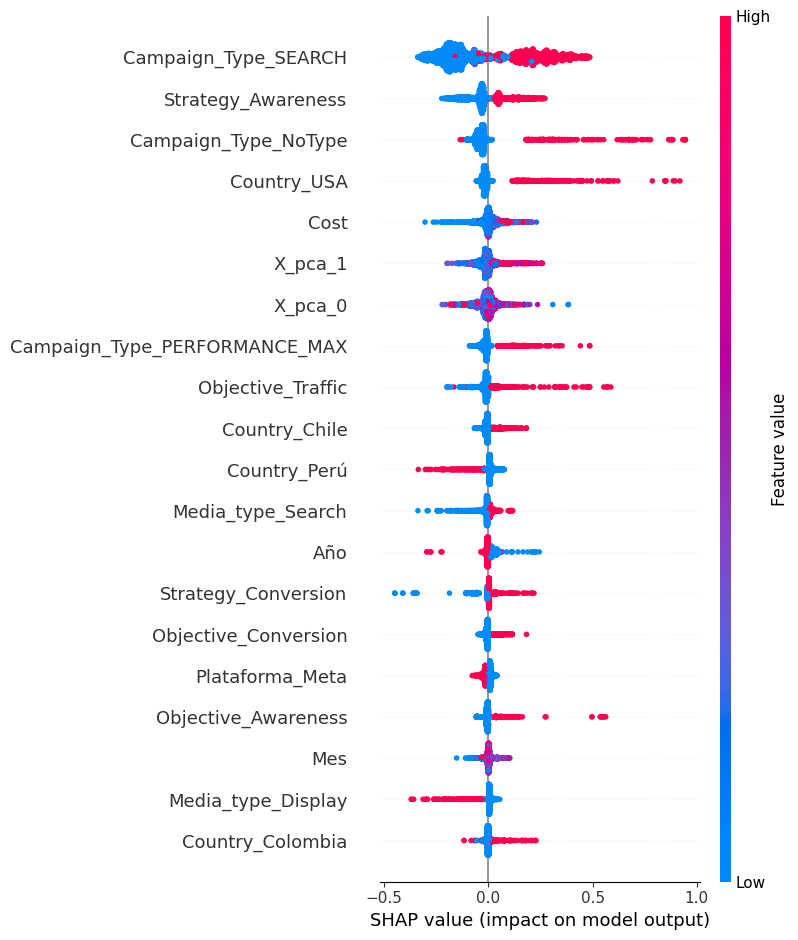

In [81]:

# Calcula los valores SHAP
explainer = shap.Explainer(xgboost)
shap_values = explainer.shap_values(X_train.drop('index',axis=1))

# Plotea los valores SHAP
shap.summary_plot(shap_values, X_train.drop('index',axis=1))

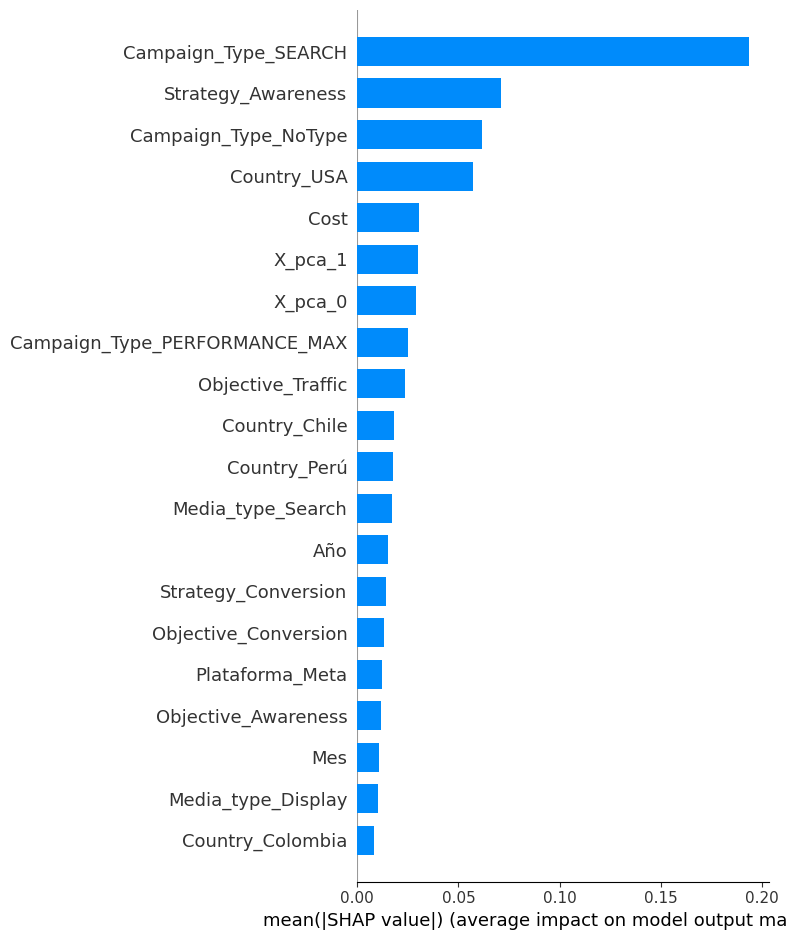

                        Feature  Importance
78         Campaign_Type_SEARCH    0.193811
57           Strategy_Awareness    0.071264
70         Campaign_Type_NoType    0.061805
26                  Country_USA    0.057344
2                          Cost    0.030649
..                          ...         ...
41            Client_QuickQuack    0.000000
43             Format_New_Video    0.000000
51   Platform_Google Ads Search    0.000000
50  Platform_Google Ads Display    0.000000
49    Platform_Google Ads  PMAX    0.000000

[85 rows x 2 columns]


In [82]:
# Obtén un resumen de los valores SHAP para identificar la importancia de cada variable
shap.summary_plot(shap_values, X_train.drop('index',axis=1), plot_type="bar")

# Accede a los valores SHAP para cada característica y calcula la importancia relativa
importance_values = abs(shap_values).mean(axis=0)

# Crea un ranking de importancia de variables
importance_ranking = pd.DataFrame(list(zip(X_train.drop('index',axis=1).columns, importance_values)), columns=['Feature', 'Importance'])
importance_ranking = importance_ranking.sort_values(by='Importance', ascending=False)

# Imprime el ranking de importancia de variables
print(importance_ranking)

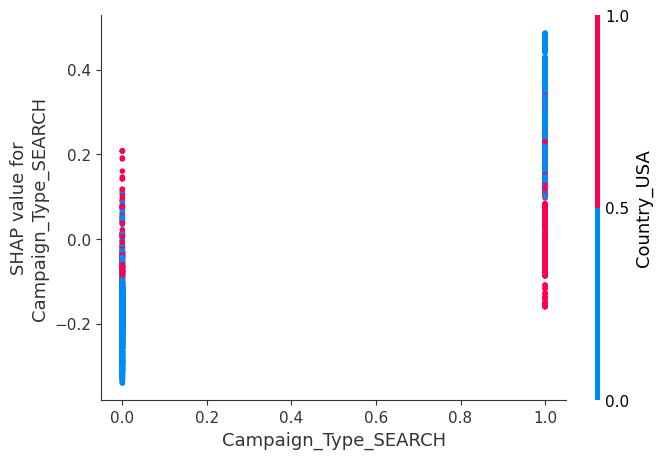

In [83]:
# Visualizar la dependencia entre variables reagrupadas y la variable objetivo
shap.dependence_plot("rank(0)", shap_values, X_train.drop('index',axis=1))

In [ ]:
print(len(importance_ranking['Importance']))
print(len(importance_ranking[importance_ranking['Importance']==0]))

In [84]:
pd.set_option('display.max_columns', None)  # Mostrar todas las columnas

In [85]:
y_test

795     0.026875
486     0.116667
3246    0.191435
3640    0.825622
684     0.295304
          ...   
258     0.716047
1551    0.956767
534     0.138578
124     0.031608
3360    0.174826
Name: CPC, Length: 857, dtype: float64

In [86]:
X_test.iloc[24:25]

,index,Año,Mes,Cost,Objective_Awareness,Objective_Category,Objective_Clicks,Objective_Consideration,Objective_Conversion,Objective_Conversions,Objective_Discovery,Objective_Fans,Objective_Impressions,Objective_Landing Page Views,Objective_NoObjective,Objective_Product,Objective_Purchase,Objective_Reach,Objective_Traffic,Objective_Views,Objective_Whatsapp,Country_Argentina,Country_Chile,Country_Colombia,Country_Ecuador,Country_Mexico,Country_Perú,Country_USA,Media_type_Display,Media_type_Search,Media_type_Social,Media_type_Unknown,Traffic_source_Facebook,Traffic_source_Google,Traffic_source_LinkedIn,Traffic_source_Other,Client_AOV,Client_Braun,Client_ChefJames,Client_Enterprise,Client_Hughesnet,Client_OldGlory,Client_QuickQuack,Format_New_Display,Format_New_Video,Platform_Discovery,Platform_Facebook,Platform_Facebook & Instagram,Platform_Facebook&Instagram,Platform_Google Ads,Platform_Google Ads PMAX,Platform_Google Ads Display,Platform_Google Ads Search,Platform_LinkedIn,Platform_NoPlatform,Platform_Performance Max,Platform_Programmatic,Platform_Search,Strategy_Awareness,Strategy_Consideration,Strategy_Conversion,Strategy_NoStrategy,Strategy_Views,Plataforma_External Source,Plataforma_Google Ads,Plataforma_Meta,Plataforma_NoPlataforma,Campaign_Type_CONVERSIONS,Campaign_Type_DISCOVERY,Campaign_Type_DISPLAY,Campaign_Type_LINK_CLICKS,Campaign_Type_NoType,Campaign_Type_OUTCOME_AWARENESS,Campaign_Type_OUTCOME_ENGAGEMENT,Campaign_Type_OUTCOME_LEADS,Campaign_Type_OUTCOME_SALES,Campaign_Type_PAGE_LIKES,Campaign_Type_PERFORMANCE_MAX,Campaign_Type_REACH,Campaign_Type_SEARCH,Ecommerce_No,Ecommerce_Si,Service_Product_Prod,Service_Product_Serv,X_pca_0,X_pca_1
3658,3700,2023,6,209.934958,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,-0.857886,-0.317918


In [87]:
resultados = pd.DataFrame()

In [88]:
resultados['Real'] = y_test

In [89]:
resultados['Pred'] = y_pred_test

In [90]:
resultados.iloc[24:25]

,Real,Pred
3700,0.697458,0.837501


In [769]:
X_test[X_test['index']==4000]

,index,Año,Mes,Cost,Objective_Awareness,Objective_Category,Objective_Clicks,Objective_Consideration,Objective_Conversion,Objective_Conversions,Objective_Discovery,Objective_Fans,Objective_Impressions,Objective_Landing Page Views,Objective_NoObjective,Objective_Product,Objective_Purchase,Objective_Reach,Objective_Traffic,Objective_Views,Objective_Whatsapp,Country_Argentina,Country_Chile,Country_Colombia,Country_Ecuador,Country_Mexico,Country_Perú,Country_USA,Media_type_Display,Media_type_Search,Media_type_Social,Media_type_Unknown,Traffic_source_Facebook,Traffic_source_Google,Traffic_source_LinkedIn,Traffic_source_Other,Client_AOV,Client_Braun,Client_ChefJames,Client_Enterprise,Client_Hughesnet,Client_OldGlory,Client_QuickQuack,Format_New_Display,Format_New_Video,Platform_Discovery,Platform_Facebook,Platform_Facebook & Instagram,Platform_Facebook&Instagram,Platform_Google Ads,Platform_Google Ads PMAX,Platform_Google Ads Display,Platform_Google Ads Search,Platform_LinkedIn,Platform_NoPlatform,Platform_Performance Max,Platform_Programmatic,Platform_Search,Strategy_Awareness,Strategy_Consideration,Strategy_Conversion,Strategy_NoStrategy,Strategy_Views,Plataforma_External Source,Plataforma_Google Ads,Plataforma_Meta,Plataforma_NoPlataforma,Campaign_Type_CONVERSIONS,Campaign_Type_DISCOVERY,Campaign_Type_DISPLAY,Campaign_Type_LINK_CLICKS,Campaign_Type_NoType,Campaign_Type_OUTCOME_AWARENESS,Campaign_Type_OUTCOME_ENGAGEMENT,Campaign_Type_OUTCOME_LEADS,Campaign_Type_OUTCOME_SALES,Campaign_Type_PAGE_LIKES,Campaign_Type_PERFORMANCE_MAX,Campaign_Type_REACH,Campaign_Type_SEARCH,Ecommerce_No,Ecommerce_Si,Service_Product_Prod,Service_Product_Serv,X_pca_0,X_pca_1
3941,4000,2022,3,739.138998,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,True,-0.239277,0.407861


In [770]:
df[df['level_0']==4000]

,level_0,AñoSemana,AñoMes,Campaign,Objective,Budget,Country,Media_type,Traffic_source,Clicks,Impressions,Cost,CPC,CPM,CTR,CPV,VR,Client,Views,Tipo,Format_New,Plataforma,Platform,Campaign_Type,Strategy,index,Ecommerce,Service_Product,Tipo Search,Bench Gral CPC,Bench Search CPC,Bench GralSch CPL,Bench Search CPL,Bench GralSch CTR,Bench Search CTR,Bench GralSch CR,Bench Search AvgCR,Tipo FB,Bench GralFB CPC,Bench FB CPC,Bench GralFB CPAction,Bench FB CPAction,Bench GralFB CTR,Bench FB CTR,Bench GralFB CR,Bench FB AvgCR,Tipo YT,Bench GralYT CPV,Bench YT CPV,Bench GralYT CTR,Bench YT CTR,Bench GralYT VR,Bench FB AvgVR,Semanas_Antiguedad,Año,Mes
4000,4000,202213,202203,ga_dsy_aov_brand_conversions_top5states_us_12-...,Conversion,739.138998,USA,Unknown,Google,2872.0,196538.0,739.138998,0.25736,3.760794,0.014613,0.0,0.0,AOV,0.0,E,Display,Google Ads,NoPlatform,SEARCH,Conversion,NaN,No,Serv,Travel,4.22,1.63,53.52,62.18,6.11,10.03,7.04,3.87,Travel & Hospitality,1.86,0.63,18.68,22.5,0.9,0.9,9.21,2.82,Travel,0.048,0.047,0.65,0.78,31.9,29.6,17,2022,3


In [771]:
y.iloc[3941]

0.2573603753481894

In [773]:
new_data = pd.DataFrame({
'Año': [2022],
'Mes': [3],
'Objective': ['Conversion'],
'Cost': [739.138998],
'Country': ['USA'],
'Media_type': ['Unknown'],
'Traffic_source': ['Google'],
'Client': ['AOV'],
'Format_New': ['Display'],
'Platform': ['NoPlatform'],
'Strategy': ['Conversion'],
'Plataforma': ['Google Ads'],
'Campaign_Type': ['SEARCH'],
'Ecommerce': ['No'],
'Service_Product': ['Serv'],
'X_pca_0': -0.239277,
'X_pca_1': 0.407861
})
new_data

,Año,Mes,Objective,Cost,Country,Media_type,Traffic_source,Client,Format_New,Platform,Strategy,Plataforma,Campaign_Type,Ecommerce,Service_Product,X_pca_0,X_pca_1
0,2022,3,Conversion,739.138998,USA,Unknown,Google,AOV,Display,NoPlatform,Conversion,Google Ads,SEARCH,No,Serv,-0.239277,0.407861


In [774]:
X[X['index']==4000]

,index,Año,Mes,Objective,Cost,Country,Media_type,Traffic_source,Client,Format_New,Platform,Strategy,Plataforma,Campaign_Type,Ecommerce,Service_Product,X_pca_0,X_pca_1
3941,4000,2022,3,Conversion,739.138998,USA,Unknown,Google,AOV,Display,NoPlatform,Conversion,Google Ads,SEARCH,No,Serv,-0.239277,0.407861


In [775]:
y_test_df = pd.DataFrame(y_test)

In [776]:
y_test_df[(y_test_df['CPC']>=0.25736)&(y_test_df['CPC']<=0.25737)]

,CPC
4000,0.25736


In [777]:
y_test_df.index.get_loc(4000)

840

In [778]:
y_pred_test[840]

0.26293498

In [779]:
# Preprocesamiento de variables categóricas
new_data = pd.get_dummies(new_data, columns=categorical_features)
variables_modelo = xgboost.feature_names_in_

# Asegurarte de que 'new_data_encoded' tenga las mismas columnas que se utilizaron durante el entrenamiento
for col in variables_modelo:
    if col not in new_data.columns:
        new_data[col] = False  # Agregar la columna faltante con valores predeterminados si es necesario

# Me aseguro de que mi nuevo dato tiene las mismas variables y el mismo orden que la data con la que fue entrenado el modelo
new_data = new_data[variables_modelo]

In [780]:
xgboost.predict(new_data)

array([0.26293498], dtype=float32)

In [745]:
datita = X_dum[X_dum['index']==4000][variables_modelo]
xgboost.predict(datita)

array([0.3166264], dtype=float32)

In [748]:
datita

,index,Año,Mes,Cost,Objective_Awareness,Objective_Category,Objective_Clicks,Objective_Consideration,Objective_Conversion,Objective_Conversions,Objective_Discovery,Objective_Fans,Objective_Impressions,Objective_Landing Page Views,Objective_NoObjective,Objective_Product,Objective_Purchase,Objective_Reach,Objective_Traffic,Objective_Views,Objective_Whatsapp,Country_Argentina,Country_Chile,Country_Colombia,Country_Ecuador,Country_Mexico,Country_Perú,Country_USA,Media_type_Display,Media_type_Search,Media_type_Social,Media_type_Unknown,Traffic_source_Facebook,Traffic_source_Google,Traffic_source_LinkedIn,Traffic_source_Other,Client_AOV,Client_Braun,Client_ChefJames,Client_Enterprise,Client_Hughesnet,Client_OldGlory,Client_QuickQuack,Format_New_Display,Format_New_Video,Platform_Discovery,Platform_Facebook,Platform_Facebook & Instagram,Platform_Facebook&Instagram,Platform_Google Ads,Platform_Google Ads PMAX,Platform_Google Ads Display,Platform_Google Ads Search,Platform_LinkedIn,Platform_NoPlatform,Platform_Performance Max,Platform_Programmatic,Platform_Search,Strategy_Awareness,Strategy_Consideration,Strategy_Conversion,Strategy_NoStrategy,Strategy_Views,Plataforma_External Source,Plataforma_Google Ads,Plataforma_Meta,Plataforma_NoPlataforma,Campaign_Type_CONVERSIONS,Campaign_Type_DISCOVERY,Campaign_Type_DISPLAY,Campaign_Type_LINK_CLICKS,Campaign_Type_NoType,Campaign_Type_OUTCOME_AWARENESS,Campaign_Type_OUTCOME_ENGAGEMENT,Campaign_Type_OUTCOME_LEADS,Campaign_Type_OUTCOME_SALES,Campaign_Type_PAGE_LIKES,Campaign_Type_PERFORMANCE_MAX,Campaign_Type_REACH,Campaign_Type_SEARCH,Ecommerce_No,Ecommerce_Si,Service_Product_Prod,Service_Product_Serv,X_pca_0,X_pca_1
3941,4000,2022,3,739.138998,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,True,-0.239277,0.407861


In [758]:
datita = datita.drop('index',axis=1)

In [216]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

In [217]:
X_train_NN = X_train.drop('index',axis=1)
X_test_NN = X_test.drop('index',axis=1)

In [218]:
scaler = StandardScaler()
X_train_scaled_NN = scaler.fit_transform(X_train_NN)
X_test_scaled_NN = scaler.transform(X_test_NN)

In [224]:
# Definir el modelo de redes neuronales para regresión
model = MLPRegressor(hidden_layer_sizes=(100,200,200,200,100,), activation='relu', alpha=0.01, solver='adam',random_state=42, max_iter=65,learning_rate_init=0.0005)

In [225]:
mse_train_list = []
mse_test_list = []
for i in range(1,65):
    print(i)

    model.partial_fit(X_train_scaled_NN, y_train)
    # Hacer predicciones en el conjunto de prueba
    y_pred_train = model.predict(X_train_scaled_NN)
    y_pred_test = model.predict(X_test_scaled_NN)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_train_list.append(mse_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    mse_test_list.append(mse_test)

df_curve = pd.DataFrame()
df_curve['train'] = mse_train_list
df_curve['test'] = mse_test_list
df_curve = df_curve.reset_index()


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


In [226]:
# Supongamos que tienes un DataFrame llamado 'df' con columnas "indice", "columna_A" y "columna_B"

# Convertir el DataFrame de pandas a un formato aceptado por Altair
df_altair = pd.melt(df_curve, id_vars=['index'], value_vars=['train', 'test'])

# Crear el gráfico de líneas divididas por color en Altair
line_chart = alt.Chart(df_altair).mark_line(point=True).encode(
    x='index:Q',
    y='value:Q',
    color='variable:N'
).properties(
    width=600,
    height=400,
    title='Gráfico de Líneas para Columnas A y B'
)

# Mostrar el gráfico
line_chart

alt.Chart(...)

In [227]:
# Hacer predicciones en el conjunto de prueba
y_pred_train_nn = model.predict(X_train_scaled_NN)
y_pred_test_nn = model.predict(X_test_scaled_NN)

In [228]:
#Calculo el MSE, MAE y r2

mse_train = mean_squared_error(y_train, y_pred_train_nn)
mse_test = mean_squared_error(y_test, y_pred_test_nn)
print(f"Error cuadrático medio en el conjunto de entrenamiento: {mse_train:.2f}")
print(f"Error cuadrático medio en el conjunto de prueba: {mse_test:.2f}")

print(f"RMSE entrenamiento: {math.sqrt(mse_train):.2f}")
print(f"RMSE prueba: {math.sqrt(mse_test):.2f}")

mae_train = mean_absolute_error(y_train, y_pred_train_nn)
mae_test = mean_absolute_error(y_test, y_pred_test_nn)
print(f"Mean Absolute Error en el conjunto de entrenamiento: {mae_train:.2f}")
print(f"Mean Absolute Error en el conjunto de prueba: {mae_test:.2f}")

r2_train = r2_score(y_train, y_pred_train_nn)
r2_test = r2_score(y_test, y_pred_test_nn)
print(f"r2 en el conjunto de entrenamiento: {r2_train:.2f}")
print(f"r2 en el conjunto de prueba: {r2_test:.2f}")

Error cuadrático medio en el conjunto de entrenamiento: 46.26
Error cuadrático medio en el conjunto de prueba: 91.90
RMSE entrenamiento: 6.80
RMSE prueba: 9.59
Mean Absolute Error en el conjunto de entrenamiento: 1.38
Mean Absolute Error en el conjunto de prueba: 1.83
r2 en el conjunto de entrenamiento: 0.54
r2 en el conjunto de prueba: 0.27


### Ensamble

(MSE: 0.053 , RMSa: 0.2, MAE: 0.4)

In [323]:
Assemble = {
    'Label_y': y_test,
    'RandomForest': y_pred_test_rf,
    'XGBoost': y_pred_test_xgb,
    'NeuralNet': y_pred_test_nn
}

Assemble['Ensamble'] = (Assemble['RandomForest']+Assemble['XGBoost']+Assemble['NeuralNet'])/3


In [325]:
Assemble = pd.DataFrame(Assemble)

In [327]:
mse_test = mean_squared_error(Assemble['Label_y'], Assemble['Ensamble'])
print(mse_test)

0.05330415556044273


In [326]:
Assemble

,Label_y,RandomForest,XGBoost,NeuralNet,Ensamble
795,0.026875,0.235428,0.135845,0.029542,0.133605
486,0.116667,0.105416,0.110455,0.089032,0.101634
3246,0.191435,0.256288,0.201405,0.151232,0.202975
3640,0.825622,0.857166,0.789986,0.794891,0.814014
684,0.295304,0.340828,0.313056,0.297815,0.317233
...,...,...,...,...,...
258,0.716047,0.696387,0.723017,0.595104,0.671503
1551,0.956767,1.123062,0.939870,0.908814,0.990582
534,0.138578,0.123834,0.133129,0.151099,0.136021
124,0.031608,0.051425,0.077662,0.032601,0.053896


In [328]:
#Calculo el MSE, MAE y r2

print(f"Error cuadrático medio en el conjunto de prueba: {mse_test:.2f}")
print(f"RMSE prueba: {math.sqrt(mse_test):.2f}")
print(f"Mean Absolute Error en el conjunto de prueba: {mae_test:.2f}")
r2_test = r2_score(Assemble['Label_y'], Assemble['Ensamble'])
print(f"r2 en el conjunto de prueba: {r2_test:.2f}")

Error cuadrático medio en el conjunto de prueba: 0.05
RMSE prueba: 0.23
Mean Absolute Error en el conjunto de prueba: 0.14
r2 en el conjunto de prueba: 0.81


In [330]:
from scipy import stats
confidence = 0.95
Assemble['squared_errors'] = (Assemble['Label_y'] - Assemble['Ensamble']) ** 2

In [337]:
interval_95 = np.sqrt(stats.t.interval(confidence, len(Assemble['squared_errors']) - 1, 
                         loc=Assemble['squared_errors'].mean(),
                         scale=stats.sem(Assemble['squared_errors']))).max()

print(interval_95)

0.2582945676138452


In [355]:
# Calculo las predicciones teniendo en cuenta el intervalo de confianza

Assemble['upper_band_90'] = Assemble['Ensamble'] + interval_95
Assemble['lower_band_90'] = Assemble['Ensamble'] - interval_95
Assemble['lower_band_90'] = np.where(Assemble['lower_band_90'] >= 0, Assemble['lower_band_90'], 0)

porc_conf = len(Assemble[(Assemble['Label_y'] > Assemble['lower_band_90'])&(Assemble['Label_y'] < Assemble['upper_band_90'])] ) / len(Assemble)
print(f"Con este intervalo de confianza son correctas {porc_conf*100:.1f} % de las predicciones")

Con este intervalo de confianza son correctas 85.8 % de las predicciones


In [360]:
# Calculo las predicciones teniendo en cuenta el intervalo de confianza expresado en porcentaje
#porc_interval = interval_95/Assemble['Ensamble'].mean()

#Assemble['upper_band_90'] = Assemble['Ensamble']*(1 + porc_interval)
#Assemble['lower_band_90'] = Assemble['Ensamble']*(1 - porc_interval)
#Assemble['lower_band_90'] = np.where(Assemble['lower_band_90'] >= 0, Assemble['lower_band_90'], 0)

#porc_conf = len(Assemble[(Assemble['Label_y'] > Assemble['lower_band_90'])&(Assemble['Label_y'] < Assemble['upper_band_90'])] ) / len(Assemble)
#print(f"Con este intervalo de confianza son correctas {porc_conf*100:.1f} % de las predicciones")

In [356]:
Assemble

,Label_y,RandomForest,XGBoost,NeuralNet,Ensamble,squared_errors,upper_band_90,lower_band_90
795,0.026875,0.235428,0.135845,0.029542,0.133605,0.011391,0.391900,0.000000
486,0.116667,0.105416,0.110455,0.089032,0.101634,0.000226,0.359929,0.000000
3246,0.191435,0.256288,0.201405,0.151232,0.202975,0.000133,0.461270,0.000000
3640,0.825622,0.857166,0.789986,0.794891,0.814014,0.000135,1.072309,0.555720
684,0.295304,0.340828,0.313056,0.297815,0.317233,0.000481,0.575528,0.058938
...,...,...,...,...,...,...,...,...
258,0.716047,0.696387,0.723017,0.595104,0.671503,0.001984,0.929797,0.413208
1551,0.956767,1.123062,0.939870,0.908814,0.990582,0.001143,1.248876,0.732287
534,0.138578,0.123834,0.133129,0.151099,0.136021,0.000007,0.394315,0.000000
124,0.031608,0.051425,0.077662,0.032601,0.053896,0.000497,0.312191,0.000000


In [359]:
grafo_2(Assemble,interval=interval_95,y_test='Label_y',y_pred_test='Ensamble')

alt.LayerChart(...)

In [358]:
#grafo_3(Assemble,porc_interval=porc_interval,y_test='Label_y',y_pred_test='Ensamble')